In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from gptools.stan import compile_model

import cmdstanpy
cmdstanpy.install_cmdstan()
import nest_asyncio
nest_asyncio.apply()

/root/.cache/pypoetry/virtualenvs/stan-env-Zdpe4cqc-py3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


CmdStan install directory: /root/.cmdstan
CmdStan version 2.33.1 already installed
Test model compilation


In [2]:
import random
from sklearn.preprocessing import LabelEncoder
df = pd.read_csv('../model_data/quality_nj2.csv')
encoder1, encoder2, encoder3, encoder4 = LabelEncoder(), LabelEncoder(), LabelEncoder(), LabelEncoder()
df['RATING_EVENT_CODE'] = encoder1.fit_transform(df['RATING_EVENT'])
df['ENTRY_NAME_CODE'] = encoder2.fit_transform(df['ENTRY_NAME'])
df['PLT_ID_CODE'] = encoder3.fit_transform(df['PLT_ID'])
df['RATER_CODE'] = encoder4.fit_transform(df['RATER'])
plt_coords = df.groupby('PLT_ID_CODE')[['ROW','COL']].mean()
#from scipy.spatial.distance import cdist
#coords = np.array([plt_coords['ROW'].values, plt_coords['COL'].values])
#distances = cdist(coords.T,coords.T, metric='euclidean')
year = pd.to_datetime(df['DATE']).dt.year
num_days_in_year = pd.to_datetime(year.astype(str), format='%Y').dt.is_leap_year * 366 + (~pd.to_datetime(year.astype(str), format='%Y').dt.is_leap_year) * 365
df['DAY_OF_YEAR'] = pd.to_datetime(df['DATE']).dt.dayofyear
df['TIME_OF_YEAR'] = df['DAY_OF_YEAR']/num_days_in_year
df['ENTRY_CUMCOUNT'] = df.groupby('ENTRY_NAME').cumcount() + 1
df.head()

/tmp/ipykernel_26413/3976686709.py:13: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  year = pd.to_datetime(df['DATE']).dt.year
/tmp/ipykernel_26413/3976686709.py:15: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['DAY_OF_YEAR'] = pd.to_datetime(df['DATE']).dt.dayofyear


,PLT_ID,TRAIT,DATE,QUALITY,ENTRY_CODE,ENTRY_NAME,COMP,RATER,ROW,COL,...,RATING_EVENT_CODE,MONTH_CODE,YEAR_CODE,TEST_LOC,ENTRY_NAME_CODE,PLT_ID_CODE,RATER_CODE,DAY_OF_YEAR,TIME_OF_YEAR,ENTRY_CUMCOUNT
0,241,Turf Quality,4/18/18,4,37,NAI-14-132,Columbia River Seed,RMD,17,1,...,7,1,1,"Adelphia, NJ",62,238,3,108,0.295890,1
1,241,Turf Quality,5/10/18,4,37,NAI-14-132,Columbia River Seed,RON,17,1,...,12,6,1,"Adelphia, NJ",62,238,4,130,0.356164,2
2,241,Turf Quality,6/7/18,5,37,NAI-14-132,Columbia River Seed,RON,17,1,...,13,4,1,"Adelphia, NJ",62,238,4,158,0.432877,3
3,241,Turf Quality,7/17/18,5,37,NAI-14-132,Columbia River Seed,RON,17,1,...,14,3,1,"Adelphia, NJ",62,238,4,198,0.542466,4
4,241,Turf Quality,8/15/18,6,37,NAI-14-132,Columbia River Seed,RMD,17,1,...,8,2,1,"Adelphia, NJ",62,238,3,227,0.621918,5


In [3]:
df.groupby('RATER_CODE')['PLT_ID'].count()

RATER_CODE
0     267
1     801
2     801
3    1335
4    3204
5    1602
6    1602
Name: PLT_ID, dtype: int64

In [4]:
df['TIME_OF_YEAR']+df['YEAR']

0       2018.295890
1       2018.356164
2       2018.432877
3       2018.542466
4       2018.621918
           ...     
9607    2021.531507
9608    2021.610959
9609    2021.712329
9610    2021.783562
9611    2021.882192
Length: 9612, dtype: float64

In [5]:
padding = 5 # adjustable
num_rows = 18
num_cols = 15
pred_N = 100
num_basis_functions = 6
stan_data_time = {"N": len(df["QUALITY"]),                 # Number of responses
             "num_raters":len(df['RATER'].unique()),         # Total number of rating events
             "num_entries":len(df['ENTRY_NAME'].unique()),           # Total number of entries (turfgrass types)
             "num_plots":len(df['PLT_ID'].unique()),               # Total number of plots 
             "num_categories": 9,                                       # Total number of rating categories
             "num_events_by_rater": df.groupby('RATER_CODE')['PLT_ID'].count(),
             "smoothing_factor": 8,
             "rater_id": df["RATER_CODE"].values+1,       # rating id for y[n], defined by rater + date
             "entry_id": df["ENTRY_NAME_CODE"].values+1,         # entry of y[n]
             "plot_id": df["PLT_ID_CODE"].values+1,             # plot id of y[n]
             "y": df["QUALITY"].values,                    # the rating value of y[n]
              # new values for fourier data
             "num_rows": num_rows,
             "num_cols": num_cols,
             "num_rows_padded": num_rows + padding,
             "num_cols_padded": num_cols + padding,
             "plot_row" : plt_coords["ROW"].astype(int),
             "plot_col" : plt_coords["COL"].astype(int),
             # values used for time GP
             "time" : df['TIME_OF_YEAR']+df['YEAR'],
             "c_f" : 1.5,
             "M_f":num_basis_functions, # number of Hilbert Basis functions
             "num_ratings_per_entry": np.max(df.groupby('ENTRY_NAME').count()['PLT_ID']),
             "entry_cumcount": df["ENTRY_CUMCOUNT"],

             "pred_N": pred_N,
             "pred_time": np.linspace(0,1,pred_N+1)[1:]
            #"pred_rating_event_id": None,
            #"pred_entry_id": None,
            #"pred_plot_id":None,
            #"pred_day":None
              }

In [7]:
fourier_model_t = compile_model(stan_file="fourier_model_time_effect_distinct_entries_v8_sharedparams.stan", force_compile=True)

08:33:32 - cmdstanpy - WARNING - CmdStanModel(compile=...) is deprecated and will be removed in the next major version. The constructor will always ensure a model has a compiled executable.
If you wish to force recompilation, use force_compile=True instead.
08:33:32 - cmdstanpy - INFO - compiling stan file /home/hok/oxb_econ/stan-env/stan_env/src/fourier_model_time_effect_distinct_entries_v8_sharedparams.stan to exe file /home/hok/oxb_econ/stan-env/stan_env/src/fourier_model_time_effect_distinct_entries_v8_sharedparams
08:34:09 - cmdstanpy - INFO - compiled model executable: /home/hok/oxb_econ/stan-env/stan_env/src/fourier_model_time_effect_distinct_entries_v8_sharedparams


In [ ]:
fit = fourier_model_t.sample(stan_data_time)

08:34:09 - cmdstanpy - INFO - CmdStan start processing
chain 1 |                                                                                                            | 00:00 Status
chain 2 |                                                                                                            | 00:00 Status

chain 3 |                                                                                                            | 00:00 Status


chain 4 |                                                                                                            | 00:00 Status

chain 3 |████▉                                                                                                       | 00:00 Status
chain 1 |████▉                                                                                                       | 00:00 Status


chain 4 |████▉                                                                                                       | 00:00 Status

chain 3 |█████

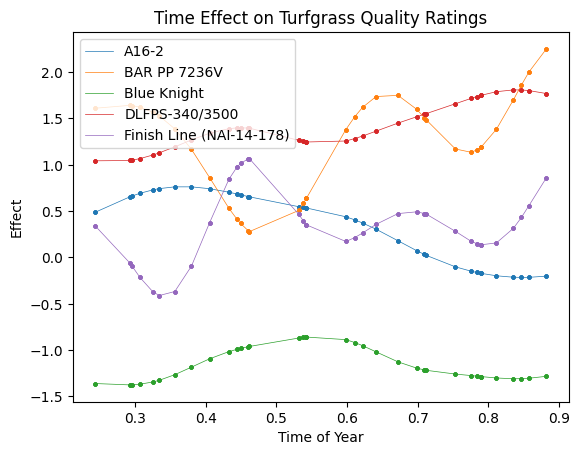

In [9]:
for i in [10,20,30,40,50]:
    x = list(df[df["ENTRY_NAME_CODE"] == i]['TIME_OF_YEAR'])
    sorted_indices = sorted(range(len(x)), key=lambda k: x[k])
    x_sorted = [list(df[df["ENTRY_NAME_CODE"] == i]['TIME_OF_YEAR'])[ind] for ind in sorted_indices]
    y_sorted = [fit.time_effect[:,i].mean(axis=0)[ind] for ind in sorted_indices]
    plt.scatter(x_sorted, y_sorted,s=5)
    plt.plot(x_sorted,y_sorted,linewidth=0.5, label=list(df[df["ENTRY_NAME_CODE"] == i]['ENTRY_NAME'])[0])
plt.title('Time Effect on Turfgrass Quality Ratings')
plt.xlabel('Time of Year')
plt.ylabel('Effect')
plt.legend()
plt.show()

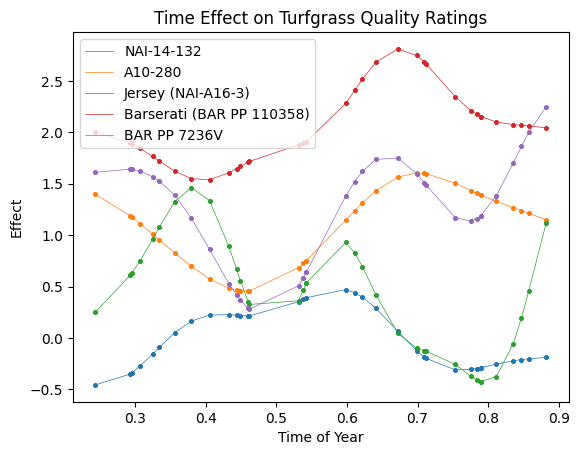

In [10]:
rand_entries = [i for i in range(stan_data_time["num_entries"])]
random.shuffle(rand_entries)
for i in rand_entries[:5]:
    x = list(df[df["ENTRY_NAME_CODE"] == i]['TIME_OF_YEAR'])
    sorted_indices = sorted(range(len(x)), key=lambda k: x[k])
    x_sorted = [list(df[df["ENTRY_NAME_CODE"] == i]['TIME_OF_YEAR'])[ind] for ind in sorted_indices]
    y_sorted = [fit.time_effect[:,i].mean(axis=0)[ind] for ind in sorted_indices]
    plt.scatter(x_sorted,y_sorted,s=5)
    plt.plot(x_sorted,y_sorted,linewidth=0.5, label=list(df[df["ENTRY_NAME_CODE"] == i]['ENTRY_NAME'])[0])
plt.title('Time Effect on Turfgrass Quality Ratings')
plt.xlabel('Time of Year')
plt.ylabel('Effect')
plt.legend()
plt.show()

<Axes: >

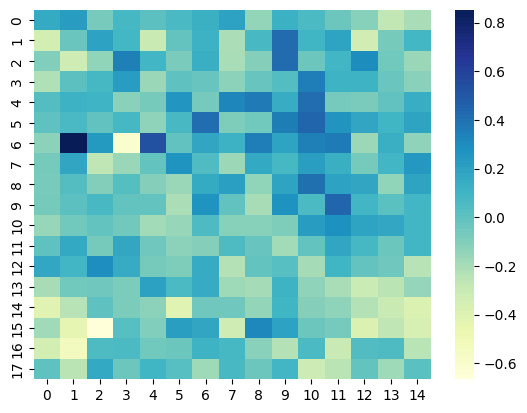

In [23]:
PLT_ROW = df.groupby('PLT_ID')[['ROW', 'COL']].max()['ROW']
PLT_COL = df.groupby('PLT_ID')[['ROW', 'COL']].max()['COL']
mean_matrix_time = np.zeros((np.max(PLT_ROW)+1, np.max(PLT_COL)+1))
mean_matrix_time[PLT_ROW, PLT_COL] = fit.plot_effect.mean(axis=0)
sns.heatmap(mean_matrix_time[1:,1:], cmap="YlGnBu")

Cross Entropy Loss: 1.0413991794792696
Cross Entropy Loss: 1.2182891334095844
Cross Entropy Loss: 2.786860742803344
Cross Entropy Loss: 1.7203738403141742
Cross Entropy Loss: 1.1731563813372539
Cross Entropy Loss: 1.3016349824363553


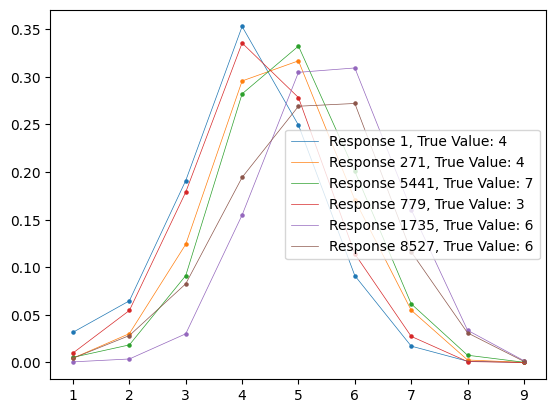

In [24]:
from scipy.special import softmax

def rsm_probability(y, theta, beta, tau):
    unsummed = np.concatenate(([0], theta - beta - tau))
    probs = softmax(np.cumsum(unsummed))
    return probs[y]
    
def cross_entropy_loss(y_true, y_pred):
    #print(y_pred)
    epsilon = 1e-15  # Small constant to avoid log(0) errors
    y_pred = np.clip(y_pred, epsilon, 1 - epsilon)  # Clip predicted probabilities to avoid extreme values
    return -np.log(y_pred[y_true])

tau = list(fit.tau_rsm.mean(axis=0))
#beta = list(fit.beta_rsm.mean(axis=0))
for n in [1]+[random.randint(0,9612) for i in range(5)]:
    #theta = fit.plot_effect.mean(axis=0)[df.loc[n]["PLT_ID_CODE"]+1] + fit.time_effect.mean(axis=0)[df.loc[n]["ENTRY_NAME_CODE"]+1][df.loc[n]["ENTRY_CUMCOUNT"]]
    thetaVec = fit.plot_effect[:,df.loc[n]["PLT_ID_CODE"]] + fit.time_effect[:,df.loc[n]["ENTRY_NAME_CODE"],df.loc[n]["ENTRY_CUMCOUNT"]-1]
    #sns.kdeplot(thetaVec)
    #beta_n = beta[df.loc[n]["RATER_CODE"]]
    tau_n = tau[df.loc[n]["RATER_CODE"]]
    probabs = np.array([[rsm_probability(i,thetaVec[j],0,tau_n) for i in range(10)] for j in range(4000)]).mean(axis=0)
    true_val = df["QUALITY"][n]
    print("Cross Entropy Loss: ",end='')
    print(cross_entropy_loss(true_val, [0]+probabs))
    plt.scatter([i for i in range(1,10)],probabs[1:],s=5)
    plt.plot([i for i in range(1,10)],probabs[1:],label=f"Response {n}, True Value: {true_val}",linewidth=0.5)
    #print(f"Response {n} True value: "+str(df["QUALITY"][n]))
plt.legend()
plt.show()

In [25]:
fit.tau_rsm.mean(axis=0).shape

(7, 9)

In [26]:
loss = []
tau = fit.tau_rsm.mean(axis=0)
for n in range(9612):
    #theta = fit.plot_effect.mean(axis=0)[df.loc[n]["PLT_ID_CODE"]+1] + fit.time_effect.mean(axis=0)[df.loc[n]["ENTRY_NAME_CODE"]+1][df.loc[n]["ENTRY_CUMCOUNT"]]
    thetaVec = fit.plot_effect[:,df.loc[n]["PLT_ID_CODE"]] + fit.time_effect[:,df.loc[n]["ENTRY_NAME_CODE"],df.loc[n]["ENTRY_CUMCOUNT"]-1]
    #sns.kdeplot(thetaVec)
    tau_n = tau[df.loc[n]["RATER_CODE"]]
    true_val = df["QUALITY"][n]
    probabs_true_val = np.array([rsm_probability(true_val,theta,0,tau_n) for theta in thetaVec]).mean()
    loss.append(-np.log(probabs_true_val))
    if n%961 == 0:
        print(n,end='')
        print(" : mean loss : "+str(np.array(loss).mean()))
print(np.array(loss).mean())

0 : mean loss : 1.4537061579399448
961 : mean loss : 1.5416449932365643
1922 : mean loss : 1.506904211295727
2883 : mean loss : 1.5039284476684864
3844 : mean loss : 1.4929256451872635
4805 : mean loss : 1.4884911629824518
5766 : mean loss : 1.4899256266114294
6727 : mean loss : 1.4923364224287605
7688 : mean loss : 1.495431917310493
8649 : mean loss : 1.492620417297366
9610 : mean loss : 1.4957933342998604
1.4958076526602806


In [27]:
fit.time_effect[:,1].mean(axis=0).shape
fit.time_effect[:,1].shape

(4000, 108)

In [28]:
fit.lengthscale_f.mean(axis=0)

array([0.91393163, 1.12024113, 0.4213666 , 0.83975255, 0.20102969,
       1.3908549 , 0.75767705, 0.88288306, 0.99569396, 1.27527205,
       1.4043209 , 1.46931287, 0.90188637, 0.78294143, 1.03923991,
       0.51152053, 1.29622407, 1.18670038, 0.73431691, 0.39508069,
       0.60245868, 0.44115585, 0.72671699, 1.54514212, 0.40079181,
       1.07853359, 0.79377951, 0.81997563, 1.34556739, 1.3992974 ,
       1.05427089, 0.91628005, 0.38320943, 0.51334107, 1.15428552,
       0.58755931, 0.99748404, 1.13216627, 0.53700544, 0.19475053,
       1.05916304, 0.41564261, 0.88717039, 0.60923211, 0.76421414,
       1.29606211, 1.35944064, 1.39530417, 0.58460567, 1.46301246,
       0.27101753, 0.29211379, 1.49689672, 1.13311737, 1.33441376,
       0.31126181, 1.36624075, 0.36003097, 1.08213641, 1.64375604,
       0.91003595, 0.53901639, 0.85371818, 1.10269985, 1.0160488 ,
       0.38821487, 1.02605382, 1.09239643, 1.65235902, 0.20853074,
       0.33309266, 0.78859332, 0.67528543, 0.74697843, 1.01031

In [29]:
fit.sigma_f.mean(axis=0)

array([0.17666504, 0.3689813 , 0.48056345, 0.56136254, 0.48233405,
       0.39685878, 0.43927116, 0.20851612, 0.48383435, 0.25870614,
       0.26298955, 0.42837071, 0.29709936, 0.37414472, 0.17342649,
       0.40262558, 0.59332999, 0.28761621, 0.59336172, 0.28390041,
       0.44573025, 0.22926456, 0.49241645, 0.45281154, 0.3247726 ,
       0.32082395, 0.30885457, 0.92955653, 0.53710422, 0.61647987,
       0.19815175, 0.29159306, 0.36863241, 0.31551909, 0.29787707,
       0.2202075 , 0.31836514, 0.21685335, 0.35634159, 0.66657826,
       0.2357559 , 0.36413909, 0.31606862, 0.38503924, 0.38573073,
       0.42485972, 0.41638066, 0.53630416, 0.32533789, 0.36638202,
       0.38199184, 0.26493562, 0.56164984, 0.53902528, 0.60073258,
       0.47594419, 0.25265034, 0.27861953, 0.40833132, 0.54501024,
       0.23993996, 0.20688479, 0.26701285, 0.51395178, 0.10868589,
       0.32403724, 0.64986708, 0.36247575, 0.4197496 , 0.58128015,
       0.51280987, 0.48996903, 0.14477889, 0.16666166, 0.15556

{0: 'DAS', 1: 'JEN', 2: 'PLV', 3: 'RMD', 4: 'RON', 5: 'SAB', 6: 'WAM'}


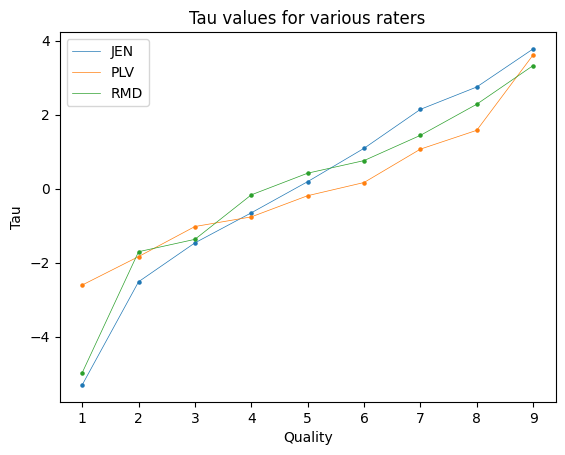

In [30]:
# make a rater dictionary
r_codes = df.groupby('RATER')['RATER_CODE'].mean()
rater_dict = {}
for j in r_codes.index:
    rater_dict[round(r_codes[j])] = j
print(rater_dict)

fit.tau_rsm.mean(axis=0)
for i in [1,2,3]:
    #tau_vals = list(fit.tau_rsm.mean(axis=0)[i])
    plt.scatter([i for i in range(1,10)],fit.tau_rsm.mean(axis=0)[i],s=5)
    plt.plot([i for i in range(1,10)],fit.tau_rsm.mean(axis=0)[i], label=rater_dict[i],linewidth=0.5)
plt.title("Tau values for various raters")
plt.xlabel("Quality")
plt.ylabel("Tau")
plt.legend()
plt.show()

{0: 'DAS', 1: 'JEN', 2: 'PLV', 3: 'RMD', 4: 'RON', 5: 'SAB', 6: 'WAM'}


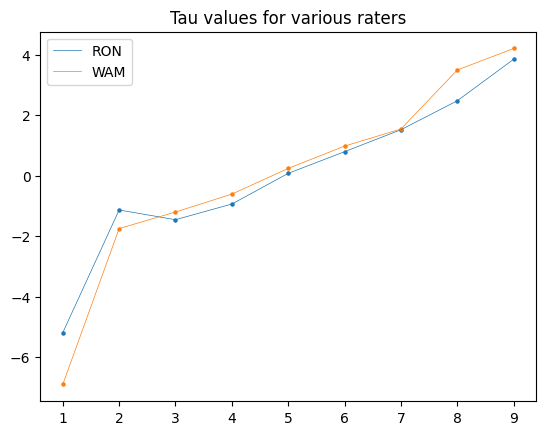

In [31]:
# make a rater dictionary
r_codes = df.groupby('RATER')['RATER_CODE'].mean()
rater_dict = {}
for j in r_codes.index:
    rater_dict[round(r_codes[j])] = j
print(rater_dict)

fit.tau_rsm.mean(axis=0)
for i in [4,6]:
    #tau_vals = list(fit.tau_rsm.mean(axis=0)[i])
    plt.scatter([i for i in range(1,10)],fit.tau_rsm.mean(axis=0)[i],s=5)
    plt.plot([i for i in range(1,10)],fit.tau_rsm.mean(axis=0)[i], label=rater_dict[i],linewidth=0.5)
plt.title("Tau values for various raters")
plt.legend()
plt.show()

In [32]:
import math
r_codes = df.groupby('RATER')['RATER_CODE'].mean()
rater_dict = {}
for j in r_codes.index:
    rater_dict[round(r_codes[j])] = j
print(rater_dict)

{0: 'DAS', 1: 'JEN', 2: 'PLV', 3: 'RMD', 4: 'RON', 5: 'SAB', 6: 'WAM'}


In [33]:
fit.intercept_f.mean(axis=0)

array([ 0.46173735,  1.13424782,  1.84065482, -0.69696551,  0.63665808,
        0.29418855,  1.45096433,  0.56072354, -0.93456431,  2.29520454,
        0.2526387 , -0.06072886,  1.77030801,  1.28364324,  0.24377489,
        0.45250878,  0.38874062,  0.08914282, -0.9991172 ,  0.63141817,
        1.45263839,  0.24338629,  1.7036149 ,  0.50579924,  0.6797381 ,
        0.05320632,  2.06262818,  1.97124389,  0.53810597,  0.96507463,
       -1.18536215,  1.65717966,  1.5277488 , -0.46137813, -0.20683309,
        0.81463038, -0.79847793,  0.11296002,  0.03823539, -0.93628573,
        1.39446752,  0.02844763, -0.21006015,  1.46237926,  0.96648447,
        1.58177369,  1.21201119,  1.32733525, -0.21784063,  0.58640808,
        0.43425817, -0.19702545,  1.12491822, -0.03518258, -0.07911443,
        0.56452617,  0.35829503, -0.8597227 , -0.14601966,  0.78001016,
       -0.32979399,  0.01816941, -0.07146057, -0.11638644,  0.543227  ,
       -0.44739812,  1.14801353, -0.19816038,  0.70184089,  2.15

Text(0.5, 1.0, 'Mean Intercept for Each Entry')

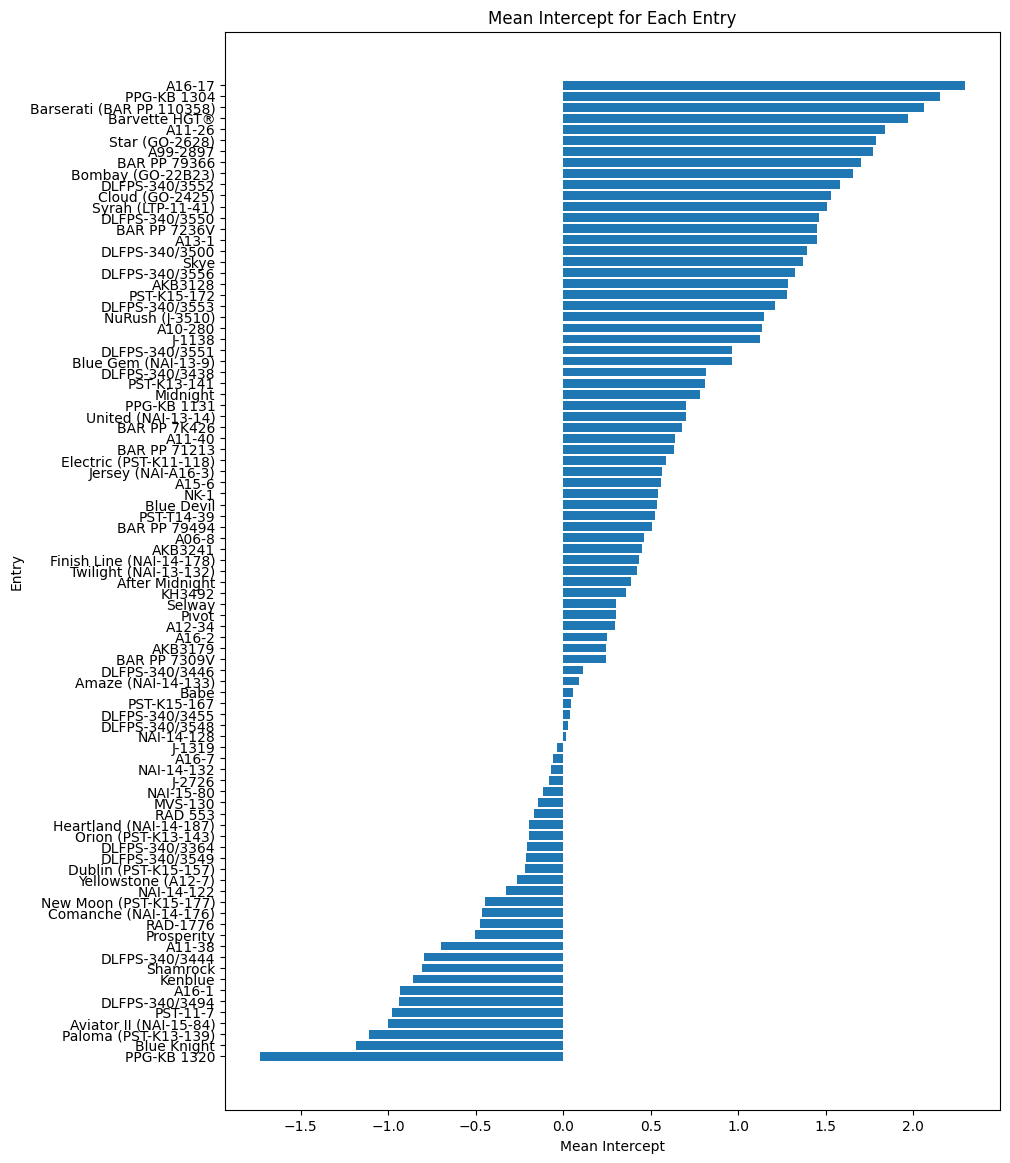

In [34]:
fig, ax = plt.subplots(figsize=(10, 14))
e_codes = df.groupby('ENTRY_NAME')['ENTRY_NAME_CODE'].mean()
entry_dict = {}
for j in e_codes.index:
    entry_dict[round(e_codes[j])] = j
intercept_f = list(fit.intercept_f.mean(axis=0))

# Generate x-axis values and corresponding entry names
y = range(len(intercept_f))
entry_names = [entry_dict[i] for i in y]

entry_names_sorted = sorted(entry_names, key = lambda x : intercept_f[entry_names.index(x)])
intercept_f_sorted = sorted(intercept_f)

bar = ax.barh(y, intercept_f_sorted)

# Set the x-axis tick labels to the entry names
ax.set_yticks(y, entry_names_sorted)

# Add labels and title
ax.set_ylabel('Entry')
ax.set_xlabel('Mean Intercept')
ax.set_title('Mean Intercept for Each Entry')

In [35]:
fit.time_effect.mean(axis=0).mean(axis=1)

array([ 4.86720092e-01,  1.08248956e+00,  2.04064040e+00, -7.02809182e-01,
        6.60691580e-01,  4.24388733e-01,  1.74878293e+00,  6.13650964e-01,
       -1.04610749e+00,  2.26800443e+00,  3.28091120e-01,  1.66707896e-01,
        1.85281107e+00,  1.08848241e+00,  2.83782632e-01,  4.96579886e-01,
        8.28819628e-01,  1.91898718e-01, -1.08623021e+00,  6.25880428e-01,
        1.24749673e+00,  2.32354415e-01,  1.92515381e+00,  7.48073631e-01,
        6.98830580e-01,  1.11763119e-01,  2.05357166e+00,  1.34052710e+00,
        6.37476524e-01,  1.19615395e+00, -1.15161665e+00,  1.82908105e+00,
        1.62462383e+00, -4.03362595e-01, -1.99859581e-01,  8.57562788e-01,
       -8.71190336e-01,  1.98861155e-01,  3.53374048e-02, -9.37610999e-01,
        1.41927103e+00, -6.47925303e-02, -2.38382170e-01,  1.47111537e+00,
        1.10847110e+00,  1.50481569e+00,  1.55338585e+00,  1.60579251e+00,
       -1.89919548e-01,  8.06492104e-01,  3.26378326e-01, -1.84034103e-01,
        1.51525962e+00,  

Text(0.5, 1.0, 'Mean Time Effect Recorded for Each Entry')

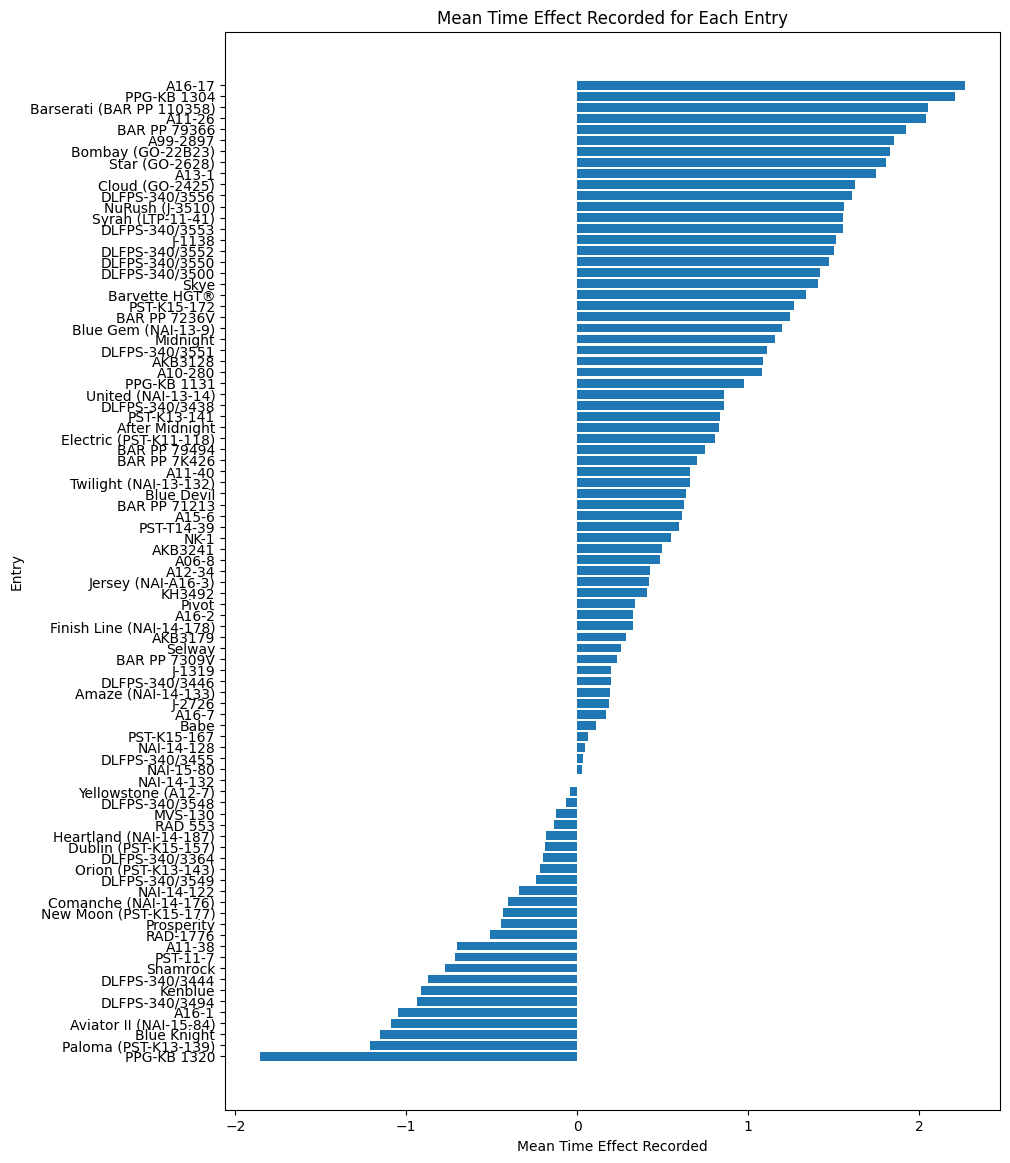

In [36]:
fig, ax = plt.subplots(figsize=(10, 14))
e_codes = df.groupby('ENTRY_NAME')['ENTRY_NAME_CODE'].mean()
entry_dict = {}
for j in e_codes.index:
    entry_dict[round(e_codes[j])] = j
intercept_f = list(fit.time_effect.mean(axis=0).mean(axis=1))

# Generate x-axis values and corresponding entry names
y = range(len(intercept_f))
entry_names = [entry_dict[i] for i in y]
entry_names_sorted = sorted(entry_names, key = lambda x : intercept_f[entry_names.index(x)])
intercept_f_sorted = sorted(intercept_f)
bar = ax.barh(y, intercept_f_sorted)

# Set the x-axis tick labels to the entry names
ax.set_yticks(y, entry_names_sorted)

# Add labels and title
ax.set_ylabel('Entry')
ax.set_xlabel('Mean Time Effect Recorded')
ax.set_title('Mean Time Effect Recorded for Each Entry')

In [13]:
fit.lengthscale_plot.mean(axis=0)

0.33288716413999997

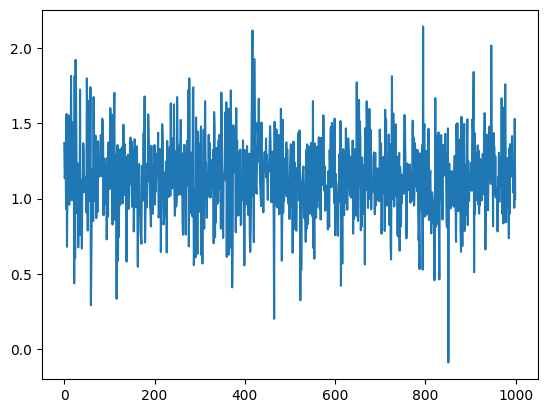

In [19]:
plt.plot(fit.intercept_f[2000:3000,1])

In [ ]:
# fit the model
fit = model.sample(data=model_data, chains=4, parallel_chains=4, adapt_delta=0.99, max_treedepth=15,
                   refresh=1, iter_warmup=200, iter_sampling=800, save_warmup=True, 
                   output_dir='./model_output/2017kbg_nj', seed=1234567,
                   time_fmt='%Y%m%d')

In [21]:
import pickle
with open("model_fit.pkl", "wb") as f:
    pickle.dump({'model' : fourier_model_t, 'fit' : fit}, f, protocol=-1)
    # or with a list
    # pickle.dump([model, fit], f, protocol=-1)